In [1]:
# -*- coding: utf-8 -*-

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [8]:
#!pip3 install requests beautifulsoup4 lxml

In [3]:
import requests
from bs4 import BeautifulSoup
import re

# 크롤링할 사이트 주소를 정의합니다.
source_url = "https://namu.wiki/RecentChanges"

# 사이트의 html 구조에 기반하여 크롤링을 수행합니다.
req = requests.get(source_url)
html = req.content
soup = BeautifulSoup(html, 'lxml')
contents_table = soup.find(name="table")
table_body = contents_table.find(name="tbody")
table_rows = table_body.find_all(name="tr")

In [4]:
# a태그의 href 속성을 리스트로 추출하여, 크롤링 할 페이지 리스트를 생성합니다.
page_url_base = "https://namu.wiki"
page_urls = []
for index in range(0, len(table_rows)):
    first_td = table_rows[index].find_all('td')[0]
    td_url = first_td.find_all('a')
    if len(td_url) > 0:
        page_url = page_url_base + td_url[0].get('href')
        if 'png' not in page_url:
            page_urls.append(page_url)

# 중복 url을 제거합니다.
page_urls = list(set(page_urls))
for page in page_urls[:5]:
    print(page)

In [5]:
req = requests.get(page_urls[0])
html = req.content
soup = BeautifulSoup(html, 'lxml')
contents_table = soup.find(name="article")
title = contents_table.find_all('h1')[0]
category = contents_table.find_all('ul')[0]
content_paragraphs = contents_table.find_all(name="div", attrs={"class":"wiki-paragraph"})
content_corpus_list = []

for paragraphs in content_paragraphs:
    content_corpus_list.append(paragraphs.text)
content_corpus = "".join(content_corpus_list)

print(title.text)
print("\n")
print(category.text)
print("\n")
print(content_corpus)

IndexError: list index out of range

In [12]:
# 크롤링한 데이터를 데이터 프레임으로 만들기 위해 준비합니다.
columns = ['title', 'category', 'content_text']
df = pd.DataFrame(columns=columns)


In [16]:
# 각 페이지별 '제목', '카테고리', '본문' 정보를 데이터 프레임으로 만듭니다.
for page_url in page_urls:

    # 사이트의 html 구조에 기반하여 크롤링을 수행합니다.
    req = requests.get(page_url)
    html = req.content
    soup = BeautifulSoup(html, 'lxml')
    contents_table = soup.find(name="article")
    title = contents_table.find_all('h1')[0]
    
    # 카테고리 정보가 없는 경우를 확인합니다.
    if len(contents_table.find_all('ul')) > 0:
        category = contents_table.find_all('ul')[0]
    else:
        category = None
        
    content_paragraphs = contents_table.find_all(name="div", attrs={"class":"wiki-paragraph"})
    content_corpus_list = []
    
    # 페이지 내 제목 정보에서 개행 문자를 제거한 뒤 추출합니다. 만약 없는 경우, 빈 문자열로 대체합니다.
    if title is not None:
        row_title = title.text.replace("\n", " ")
    else:
        row_title = ""
    
    # 페이지 내 본문 정보에서 개행 문자를 제거한 뒤 추출합니다. 만약 없는 경우, 빈 문자열로 대체합니다.
    if content_paragraphs is not None:
        for paragraphs in content_paragraphs:
            if paragraphs is not None:
                content_corpus_list.append(paragraphs.text.replace("\n", " "))
            else:
                content_corpus_list.append("")
    else:
        content_corpus_list.append("")
        
    # 페이지 내 카테고리정보에서 “분류”라는 단어와 개행 문자를 제거한 뒤 추출합니다. 만약 없는 경우, 빈 문자열로 대체합니다.
    if category is not None:
        row_category = category.text.replace("\n", " ")
    else:
        row_category = ""
    
    # 모든 정보를 하나의 데이터 프레임에 저장합니다.
    row = [row_title, row_category, "".join(content_corpus_list)]
    series = pd.Series(row, index=df.columns)
    df = df.append(series, ignore_index=True)


In [17]:
# 데이터 프레임을 출력합니다.
df.head(5)

,title,category,content_text
0,GO HOME,일본 게임2020년 게임호러 게임일본을 배경으로 한 작품,Go Home개발市松寿ゞ謡엔진언리얼 엔진플랫폼 | 장르호러버전v1.04 (프리 버전...
1,임나은,트위치 스트리머/ㅇ대한민국의 여성 인터넷 방송인/ㅇ,임나은ao_o5예명임나은성별여성나이비공개생일10월 27일키160.3[1]혈액형A형M...
2,유호빈,싸움독학/등장인물,이 문서에 스포일러가 포함되어 있습니다.이 문서가 설명하는 작품이나 인물 등에 대한...
3,국민의힘/제1차 전당대회,국민의힘,[ 펼치기 · 접기 ]역사2020년 · 2021년다른 정당과의 관계전당대회역대 ...
4,도시아이들,가수,1. 개요2. 활동3. 근황김창남과 박일서로 구성되었던 2인조 가수였지만 현재는 해...


In [18]:
# 텍스트 정제 함수 : 한글 이외의 문자는 전부 제거합니다.
def text_cleaning(text):
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+') # 한글의 정규표현식을 나타냅니다.
    result = hangul.sub('', text)
    return result

In [19]:
print(text_cleaning(df['content_text'][0]))

 개발엔진언리얼 엔진플랫폼  장르호러버전 프리 버전관련 사이트개발자 유튜브 개발자 트위터프리 버전 다운로드 페이지 스팀 상점 페이지 구글 플레이 앱 다운로드 페이지 개요 조작법 프리 버전 컴플리트 버전 스테이지  스테이지  스테이지  스테이지  스테이지  보스전 스테이지  엔딩 해석 사운드트랙 여담 은 일본의 버츄얼 유튜버 가 제작한  호러 게임이다프리 버전 기준으로 작성되어 있다 컴플리트 버전에서는 약간 다를 수 있다 이동 점프 앉기 달리기 스태미나가 있어 일정시간 달리다 보면 주인공이 숨차는 소리를 내며 달리기가 중지된다 스태미나가 점점 회복되는 시스템이 아니라 달리기가 중지되면 다시 일정시간 달릴 수 있게 된다 스테이지에서 목적지집의 위치를 주인공이 손가락으로 가리킨다 위 사진의 조작법을 다시 표시해준다 인칭 시점 변환이지만 버전 기준 카메라의 위치가 잘못 설정되었는지 바라보는 방향 조금 앞에서 인칭 시점이 적용된다최초로 공개된 버전이다 홈페이지에서 무료로 다운로드할 수 있다주인공의 복장 신호등에서 도랸세가 흘러나오는 점 참배 이후에 악귀가 쫓아온다는 점 등으로 보아 일본의 풍습인 시치고산을 모티브로 한 것으로 보인다앞에 보이는 신사에 참배를 하고 돌아간다 계단을 내려가면 횡단보도가 있는데 신호등이 빨간 불일 때 건너려고 하면 차가 갑툭튀해 바로 게임오버 당하니 주의횡단보도를 지나면 길 한가운데에 맨홀이 있는데 밟으면 특정 위치로 순간이동을 할 수 있다 맨홀을 지나 앞으로 쭉 가면 스테이지가 시작된다스테이지에서는 키를 활용해 집의 위치를 파악해야 한다 앞으로 가면 기괴하게 얼굴을 부풀리는 여자가 다가오는데 일정거리 이상 좁혀지면 크시코스의 우편마차 이 들리면서 미친듯이 뛰어온다 매우 빠르기 때문에 달리기로는 도망칠 수 없고 잡히기 전에 맨홀을 밟아서 순간이동해야 한다 집빌라을 찾아도 정문으로 바로 들어가려고 하면 갑자기 귀신이 덮치는 페이크가 있다 우회해서 들어가야 하는데 우회로를 따라 가다보면 앞에서 귀신이 튀어나와 쫓아오니 맨홀로 한 번 도망치고 다시

In [20]:
# 각 피처마다 데이터 전처리를 적용합니다.
df['title'] = df['title'].apply(lambda x: text_cleaning(x))
df['category'] = df['category'].apply(lambda x: text_cleaning(x))
df['content_text'] = df['content_text'].apply(lambda x: text_cleaning(x))
df.head(5)

,title,category,content_text
0,,일본 게임년 게임호러 게임일본을 배경으로 한 작품,개발엔진언리얼 엔진플랫폼 장르호러버전 프리 버전관련 사이트개발자 유튜브 개발자 ...
1,임나은,트위치 스트리머ㅇ대한민국의 여성 인터넷 방송인ㅇ,임나은예명임나은성별여성나이비공개생일월 일키혈액형형퍼스널 컬러분홍색 팬덤명초롱단주 콘...
2,유호빈,싸움독학등장인물,이 문서에 스포일러가 포함되어 있습니다이 문서가 설명하는 작품이나 인물 등에 대한 ...
3,국민의힘제차 전당대회,국민의힘,펼치기 접기 역사년 년다른 정당과의 관계전당대회역대 전당대회 차 전당대회...
4,도시아이들,가수,개요 활동 근황김창남과 박일서로 구성되었던 인조 가수였지만 현재는 해체되었다년에 ...


In [21]:
# 각 피처마다 말뭉치를 생성합니다.
title_corpus = "".join(df['title'].tolist())
category_corpus = "".join(df['category'].tolist())
content_corpus = "".join(df['content_text'].tolist())
print(title_corpus)

  임나은 유호빈 국민의힘제차 전당대회 도시아이들 쿠키런 킹덤쿠키특별한 인연 김나라프로게이머 이주헌축구 주둔병단 하드커널 일본 본토 공습 최종훈푸른거탑 또뜨 세인트   이벤트  발로란트  버드 블랙   임나은 유호빈 국민의힘제차 전당대회 도시아이들 쿠키런 킹덤쿠키특별한 인연 김나라프로게이머 이주헌축구 주둔병단 하드커널 일본 본토 공습 최종훈푸른거탑 또뜨 세인트   이벤트  발로란트  버드 블랙 베른하르트 폰 슈나이더 아일랜드 오브 어드벤처 자국 혐오행태 헨리 포드 토탈 워 워해머 발매 전 정보 스페셜 위크 짝짝짝 트리오 양의지년 파일대박부동산   휴지통   게키류가 메데이아 벨리아르 정미의병 독립민주세르비아당 브롤스타즈게임 모드보스전 김하나푸른거탑 유이배우 응웬 반 티우 가상 국가 모터스 미라쥬 시리즈 꼬꼬면 문재인별명 류지현야구년 보이는 여고생 눈물나는 희생게임 소에지마 다네오미 큐레이터 우주 마틴 프리먼 크리스티나 그리미 엘리베이터 광교중앙역 스윕 토쇼우마무스메     빛의 아이들 데이비드 로버슨 다이어 스트레이츠 박중사 정수라 엔케이컨텐츠   모드  휴지통   김준태야구선수년 년 재보궐선거 여호와의 증인 박종윤축구해설가 호매실역 갈라파고스땅거북 카메오 크리스찬 라 몬테 더비 카운티  시즌리그 내과 박원장 우주소녀 더 블랙 콜 오브 듀티  모던 워페어캠페인 반여단 홍준표 하이브웹툰 휴지통   먹튀야구 리그 휴지통   모티스 고속버스 성남광주 김호창푸른거탑 행보관푸른거탑 격기 반 


In [22]:
from konlpy.tag import Okt
from collections import Counter

# konlpy의 형태소 분석기로 명사 단위의 키워드를 추출합니다.
nouns_tagger = Okt()
nouns = nouns_tagger.nouns(content_corpus)
count = Counter(nouns)

In [23]:
count

Counter({'개발': 68,
         '엔진': 79,
         '리얼': 8,
         '플랫폼': 10,
         '장르': 20,
         '호러': 14,
         '버전': 92,
         '프리': 53,
         '관련': 260,
         '사이트': 32,
         '개발자': 23,
         '유튜브': 92,
         '트위터': 15,
         '다운로드': 11,
         '페이지': 27,
         '스팀': 16,
         '상점': 6,
         '구글': 9,
         '플레이': 109,
         '앱': 3,
         '개요': 78,
         '작법': 4,
         '컴': 11,
         '리트': 8,
         '스테이지': 93,
         '보스': 322,
         '전': 414,
         '엔딩': 38,
         '해석': 26,
         '사운드트랙': 4,
         '여담': 112,
         '은': 85,
         '일본': 513,
         '버츄얼': 2,
         '유튜버': 19,
         '제작': 51,
         '게임': 289,
         '기준': 128,
         '작성': 22,
         '약간': 61,
         '수': 1247,
         '이동': 99,
         '점프': 27,
         '달리기': 19,
         '스태미나': 4,
         '일정': 40,
         '시간': 259,
         '달리': 131,
         '주인공': 192,
         '숨': 6,
         '소리': 153,
         '중지'

In [24]:
# 한글자 키워드를 제거합니다.
remove_char_counter = Counter({x : count[x] for x in count if len(x) > 1})
print(remove_char_counter)

Counter({'문단': 1736, '문서': 1658, '이전': 1542, '역사': 1513, '쿠키': 1102, '때문': 913, '한국': 697, '경우': 658, '사람': 614, '이후': 608, '정도': 565, '토론': 550, '공격': 525, '합의': 524, '시즌': 519, '사항': 518, '일본': 513, '다른': 500, '체력': 477, '모습': 466, '자신': 431, '경기': 428, '부분': 410, '대한': 402, '사실': 390, '귀신': 367, '엘리베이터': 366, '시작': 361, '등장': 355, '문제': 351, '생각': 345, '하나': 344, '내용': 337, '사용': 335, '티스': 328, '보스': 322, '당시': 321, '이상': 318, '상황': 310, '폭격': 309, '위해': 298, '또한': 297, '게임': 289, '가장': 288, '말년': 283, '다시': 278, '매우': 272, '본인': 266, '이름': 265, '별명': 263, '관련': 260, '시간': 259, '미국': 259, '기록': 248, '이벤트': 238, '자체': 231, '선수': 224, '대표': 224, '이유': 221, '방송': 221, '유호': 220, '영상': 219, '상대': 218, '현재': 216, '스타': 215, '거의': 212, '기술': 212, '라면': 209, '문재인': 205, '출연': 199, '해당': 198, '사건': 198, '언급': 197, '일부': 195, '모드': 195, '주인공': 192, '가지': 191, '병장': 191, '다만': 190, '모든': 189, '상태': 187, '역시': 187, '실제': 187, '시절': 186, '능력': 186, '존재': 185, '모두': 184, '미코': 184, '처음': 183, '

In [25]:
# 한국어 약식 불용어사전 예시 파일입니다. 출처 - (https://www.ranks.nl/stopwords/korean)
korean_stopwords_path = "../data/korean_stopwords.txt"

# 텍스트 파일을 오픈합니다.
with open(korean_stopwords_path, encoding='utf8') as f:
    stopwords = f.readlines()
stopwords = [x.strip() for x in stopwords]
print(stopwords[:10])

['아', '휴', '아이구', '아이쿠', '아이고', '어', '나', '우리', '저희', '따라']


In [26]:
# 나무위키 페이지에 맞는 불용어를 추가합니다.
namu_wiki_stopwords = ['상위', '문서', '내용', '누설', '아래', '해당', '설명', '표기', '추가', '모든', '사용', '매우', '가장',
                       '줄거리', '요소', '상황', '편집', '틀', '경우', '때문', '모습', '정도', '이후', '사실', '생각', '인물', 
                       '이름', '년월']
for stopword in namu_wiki_stopwords:
    stopwords.append(stopword)

In [ ]:
#!pip install pytagcloud pygame simplejson

In [27]:
import random
import pytagcloud
import webbrowser

pygame 2.0.1 (SDL 2.0.14, Python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [28]:
# 가장 출현 빈도수가 높은 40개의 단어를 선정합니다.
ranked_tags = remove_char_counter.most_common(40)

# pytagcloud로 출력할 40개의 단어를 입력합니다. 단어 출력의 최대 크기는 80으로 제한합니다.
taglist = pytagcloud.make_tags(ranked_tags, maxsize=80)

# pytagcloud 이미지를 생성합니다. 폰트는 나눔 고딕을 사용합니다.
pytagcloud.create_tag_image(taglist, 'wordcloud.jpg', size=(900, 600), fontname='NanumGothic', rectangular=False)

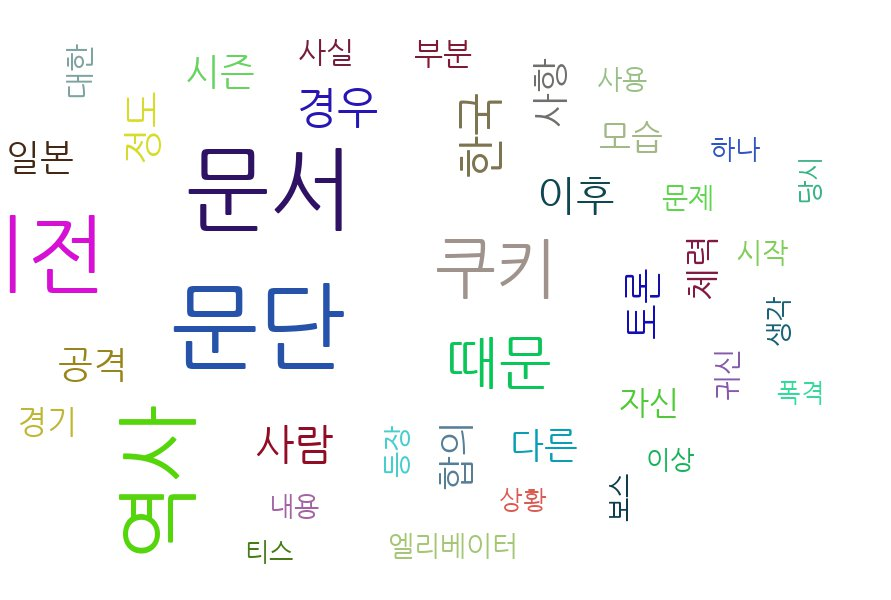

In [29]:
# 생성한 이미지를 주피터 노트북상에서 출력합니다.
from IPython.display import Image
Image(filename='wordcloud.jpg')

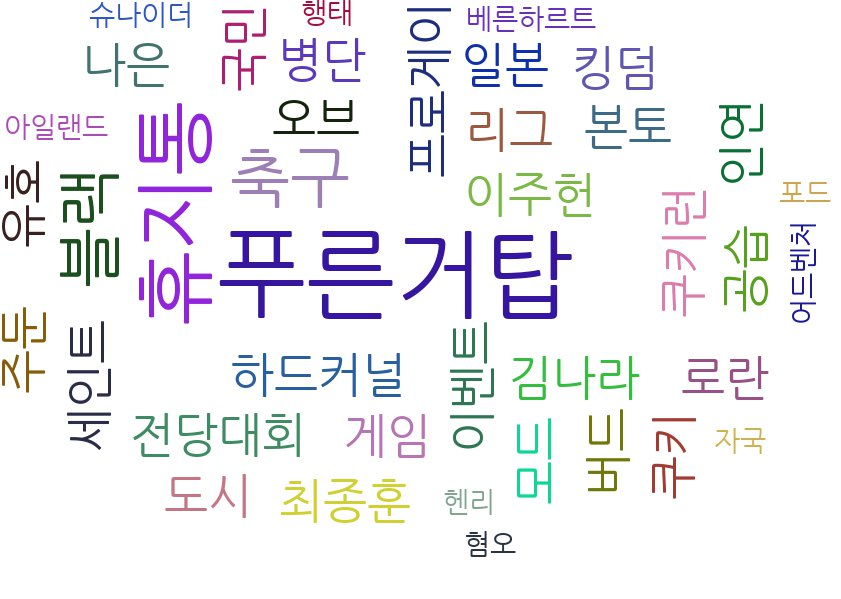

In [30]:
nouns_tagger = Okt()
nouns = nouns_tagger.nouns(title_corpus)
count = Counter(nouns)

remove_char_counter = Counter({x : count[x] for x in count if len(x) > 1})
remove_char_counter = Counter({x : remove_char_counter[x] for x in count if x not in stopwords})

ranked_tags = remove_char_counter.most_common(40)
taglist = pytagcloud.make_tags(ranked_tags, maxsize=80)
pytagcloud.create_tag_image(taglist, 'title_wordcloud.jpg', size=(900, 600), fontname='NanumGothic', rectangular=False)

Image(filename='title_wordcloud.jpg')

In [31]:
count

Counter({'임': 2,
         '나은': 2,
         '유호': 2,
         '빈': 2,
         '국민': 2,
         '힘': 2,
         '차': 2,
         '전당대회': 2,
         '도시': 2,
         '아이': 3,
         '쿠키런': 2,
         '킹덤': 2,
         '쿠키': 2,
         '인연': 2,
         '김나라': 2,
         '프로게이머': 2,
         '이주헌': 2,
         '축구': 3,
         '주둔': 2,
         '병단': 2,
         '하드커널': 2,
         '일본': 2,
         '본토': 2,
         '공습': 2,
         '최종훈': 2,
         '푸른거탑': 5,
         '또': 2,
         '세인트': 2,
         '이벤트': 2,
         '발': 2,
         '로란': 2,
         '트': 2,
         '버드': 2,
         '블랙': 3,
         '베른하르트': 1,
         '폰': 1,
         '슈나이더': 1,
         '아일랜드': 1,
         '오브': 2,
         '어드벤처': 1,
         '자국': 1,
         '혐오': 1,
         '행태': 1,
         '헨리': 1,
         '포드': 1,
         '토탈': 1,
         '워': 2,
         '워해머': 1,
         '발매': 1,
         '전': 2,
         '정보': 1,
         '스페셜': 1,
         '위': 1,
         '짝짝': 1,
         '짝':

In [34]:
dic_count = dict(count)
dic_count['축구']

3

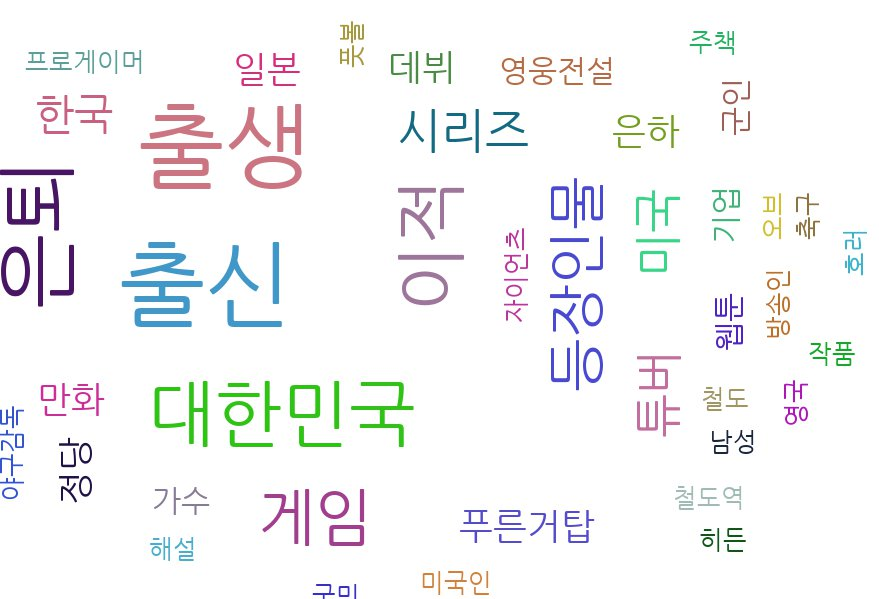

In [35]:
nouns_tagger = Okt()
nouns = nouns_tagger.nouns(category_corpus)
count = Counter(nouns)

remove_char_counter = Counter({x : count[x] for x in count if len(x) > 1})
remove_char_counter = Counter({x : remove_char_counter[x] for x in count if x not in stopwords})

ranked_tags = remove_char_counter.most_common(40)
taglist = pytagcloud.make_tags(ranked_tags, maxsize=80)
pytagcloud.create_tag_image(taglist, 'category_wordcloud.jpg', size=(900, 600), fontname='NanumGothic', rectangular=False)

Image(filename='category_wordcloud.jpg')

In [ ]:
from konlpy.tag import Okt

In [ ]:
t = Okt()

In [ ]:
tokens_ko = t.nouns("나는 가방에 들어갈거야..가방..가방...진짜야..진짜..진짜..진짜..진짜..오늘은 수요일이야..오늘")
tokens_ko

In [ ]:
import nltk

In [ ]:
ko = nltk.Text(tokens_ko, name='test') 

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm  # 폰트 관련 용도
 
%config InlineBackend.figure_format = 'retina'

In [ ]:
import matplotlib.font_manager as fm
fontpath = 'C:/ProgramData/Anaconda3/Lib/site-packages/pytagcloud/fonts/NanumGothic.ttf'
font_name = fm.FontProperties(fname=fontpath, size=9).get_name()
plt.rc('font', family=font_name) 


In [ ]:
fm._rebuild() #폰트 설정 반영

In [ ]:
plt.figure(figsize=(14,6))
ko.plot(50)
plt.show()

In [ ]:
coun